In [25]:
import math
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *
from torchdyn.core import NeuralODE

from sklearn.model_selection import train_test_split
from ot.sliced import sliced_wasserstein_distance

In [12]:
# set seed
seed = 1980
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

In [13]:
S40 = pd.read_csv("data/station_40.csv")
S49 = pd.read_csv("data/station_49.csv")
S63 = pd.read_csv("data/station_63.csv")
S80 = pd.read_csv("data/station_80.csv")

S40.rename(columns=lambda x: x + "_40" if x != "YEAR" else x, inplace=True)
S49.rename(columns=lambda x: x + "_49" if x != "YEAR" else x, inplace=True)
S63.rename(columns=lambda x: x + "_63" if x != "YEAR" else x, inplace=True)
S80.rename(columns=lambda x: x + "_80" if x != "YEAR" else x, inplace=True)

merged_df = pd.merge(S40, S49, on='YEAR', how='inner')
merged_df = pd.merge(merged_df, S63, on='YEAR', how='inner')
dataset = pd.merge(merged_df, S80, on='YEAR', how='inner')

dataset.set_index('YEAR', inplace=True)
target = ['YIELD_40', 'YIELD_49', 'YIELD_63', 'YIELD_80']
features = [x for x in dataset.columns if x not in target]

print(dataset.shape)
dataset.head()

(10000, 76)


W_1_40     W_2_40     W_3_40     W_4_40     W_5_40     W_6_40  \
YEAR                                                                     
0     21.389266  26.985066  23.813756  26.852214  25.096705  26.852109   
1     21.314074  22.516442  24.072042  29.159849  29.522392  26.567033   
2     20.875083  26.038845  24.516708  27.633776  26.951667  27.926496   
3     20.553688  20.992986  22.859027  28.654018  26.705206  24.458350   
4     21.523342  21.542900  23.034072  26.327315  30.362289  27.503657   

         W_7_40     W_8_40     W_9_40   W_10_40  ...   W_10_80   W_11_80  \
YEAR                                             ...                       
0     25.730293  23.416002  21.038240  5.739711  ...  1.027391  1.228816   
1     28.249854  24.606161  19.268685  1.891106  ...  0.143191  0.925005   
2     26.534607  25.968638  23.554623  4.745318  ...  0.942601  1.811827   
3     25.146936  21.531644  22.961974  8.479863  ...  3.640015  0.956474   
4     27.839165  29.764479  18.290963  3.405621  ...  1.191167  0.049557   

       W_12_80   W_13_80   W_14_80   W_15_80   W_16_80   W_17_80   W_18_80  \
YEAR                                                                         
0     1.324273  2.309497  2.917570  0.769869  0.907157  3.401885  1.037317   
1     2.751680  1.196560  0.784046  1.505209  0.240757  1.617603  1.818209   
2     2.923051  0.384716  2.876004  1.535451  1.509938  1.652338  0.279352   
3     2.241502  1.893830  0.189264  2.049275  3.795690  0.404447  1.468172   
4     0.330440  2.860207  0.399063  0.506497  1.700047  0.216837  2.166599   

      YIELD_80  
YEAR            
0        10.51  
1         6.61  
2         6.86  
3         5.32  
4         6.32  

[5 rows x 76 columns]

In [14]:
dataset['Q40'] = (dataset['W_13_40'] + dataset['W_14_40'] + dataset['W_15_40'])
dataset['Q49'] = (dataset['W_13_49'] + dataset['W_14_49'] + dataset['W_15_49'])
dataset['Q63'] = (dataset['W_13_63'] + dataset['W_14_63'] + dataset['W_15_63'])
dataset['Q80'] = (dataset['W_13_80'] + dataset['W_14_80'] + dataset['W_15_80'])

features = ['YIELD_40', 'YIELD_49', 'YIELD_63', 'YIELD_80']
aux_columns = ['Q40', 'Q49', 'Q63', 'Q80']
nb_weather_var = len([x for x in dataset.columns if not (x in features or x in aux_columns) ])

dataset = dataset[(dataset['Q40'] <= 6.4897) & (dataset['Q49'] <= 3.3241) & (dataset['Q63'] <= 7.1301) & (dataset['Q80'] <= 5.1292)]
dataset.drop(['Q40', 'Q49', 'Q63', 'Q80'], axis=1, inplace=True)
print(dataset.shape)
dataset.head()

(1000, 76)


W_1_40     W_2_40     W_3_40     W_4_40     W_5_40     W_6_40  \
YEAR                                                                     
1     21.314074  22.516442  24.072042  29.159849  29.522392  26.567033   
2     20.875083  26.038845  24.516708  27.633776  26.951667  27.926496   
10    23.464658  23.112057  27.032350  26.348370  26.635686  27.142812   
28    24.495898  23.278987  23.563798  27.221256  25.471418  28.230339   
33    22.954317  23.373752  24.817940  26.166261  28.014204  29.420747   

         W_7_40     W_8_40     W_9_40   W_10_40  ...   W_10_80   W_11_80  \
YEAR                                             ...                       
1     28.249854  24.606161  19.268685  1.891106  ...  0.143191  0.925005   
2     26.534607  25.968638  23.554623  4.745318  ...  0.942601  1.811827   
10    30.421238  24.051925  18.585785  0.692692  ...  0.587621  0.473142   
28    27.622846  23.942648  20.273115  2.315491  ...  0.169986  0.376775   
33    27.174332  26.733400  20.511923  0.827020  ...  1.526391  3.749390   

       W_12_80   W_13_80   W_14_80   W_15_80   W_16_80   W_17_80   W_18_80  \
YEAR                                                                         
1     2.751680  1.196560  0.784046  1.505209  0.240757  1.617603  1.818209   
2     2.923051  0.384716  2.876004  1.535451  1.509938  1.652338  0.279352   
10    0.816458  0.573914  0.174179  2.236641  0.175408  2.514701  2.153090   
28    1.874452  0.343077  1.527473  0.417273  0.691531  2.872908  1.997046   
33    0.511152  0.536142  0.158058  0.958499  2.007874  0.499257  4.017396   

      YIELD_80  
YEAR            
1         6.61  
2         6.86  
10        6.04  
28        6.08  
33        3.51  

[5 rows x 76 columns]

In [15]:
#Train / Test split :
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=seed)

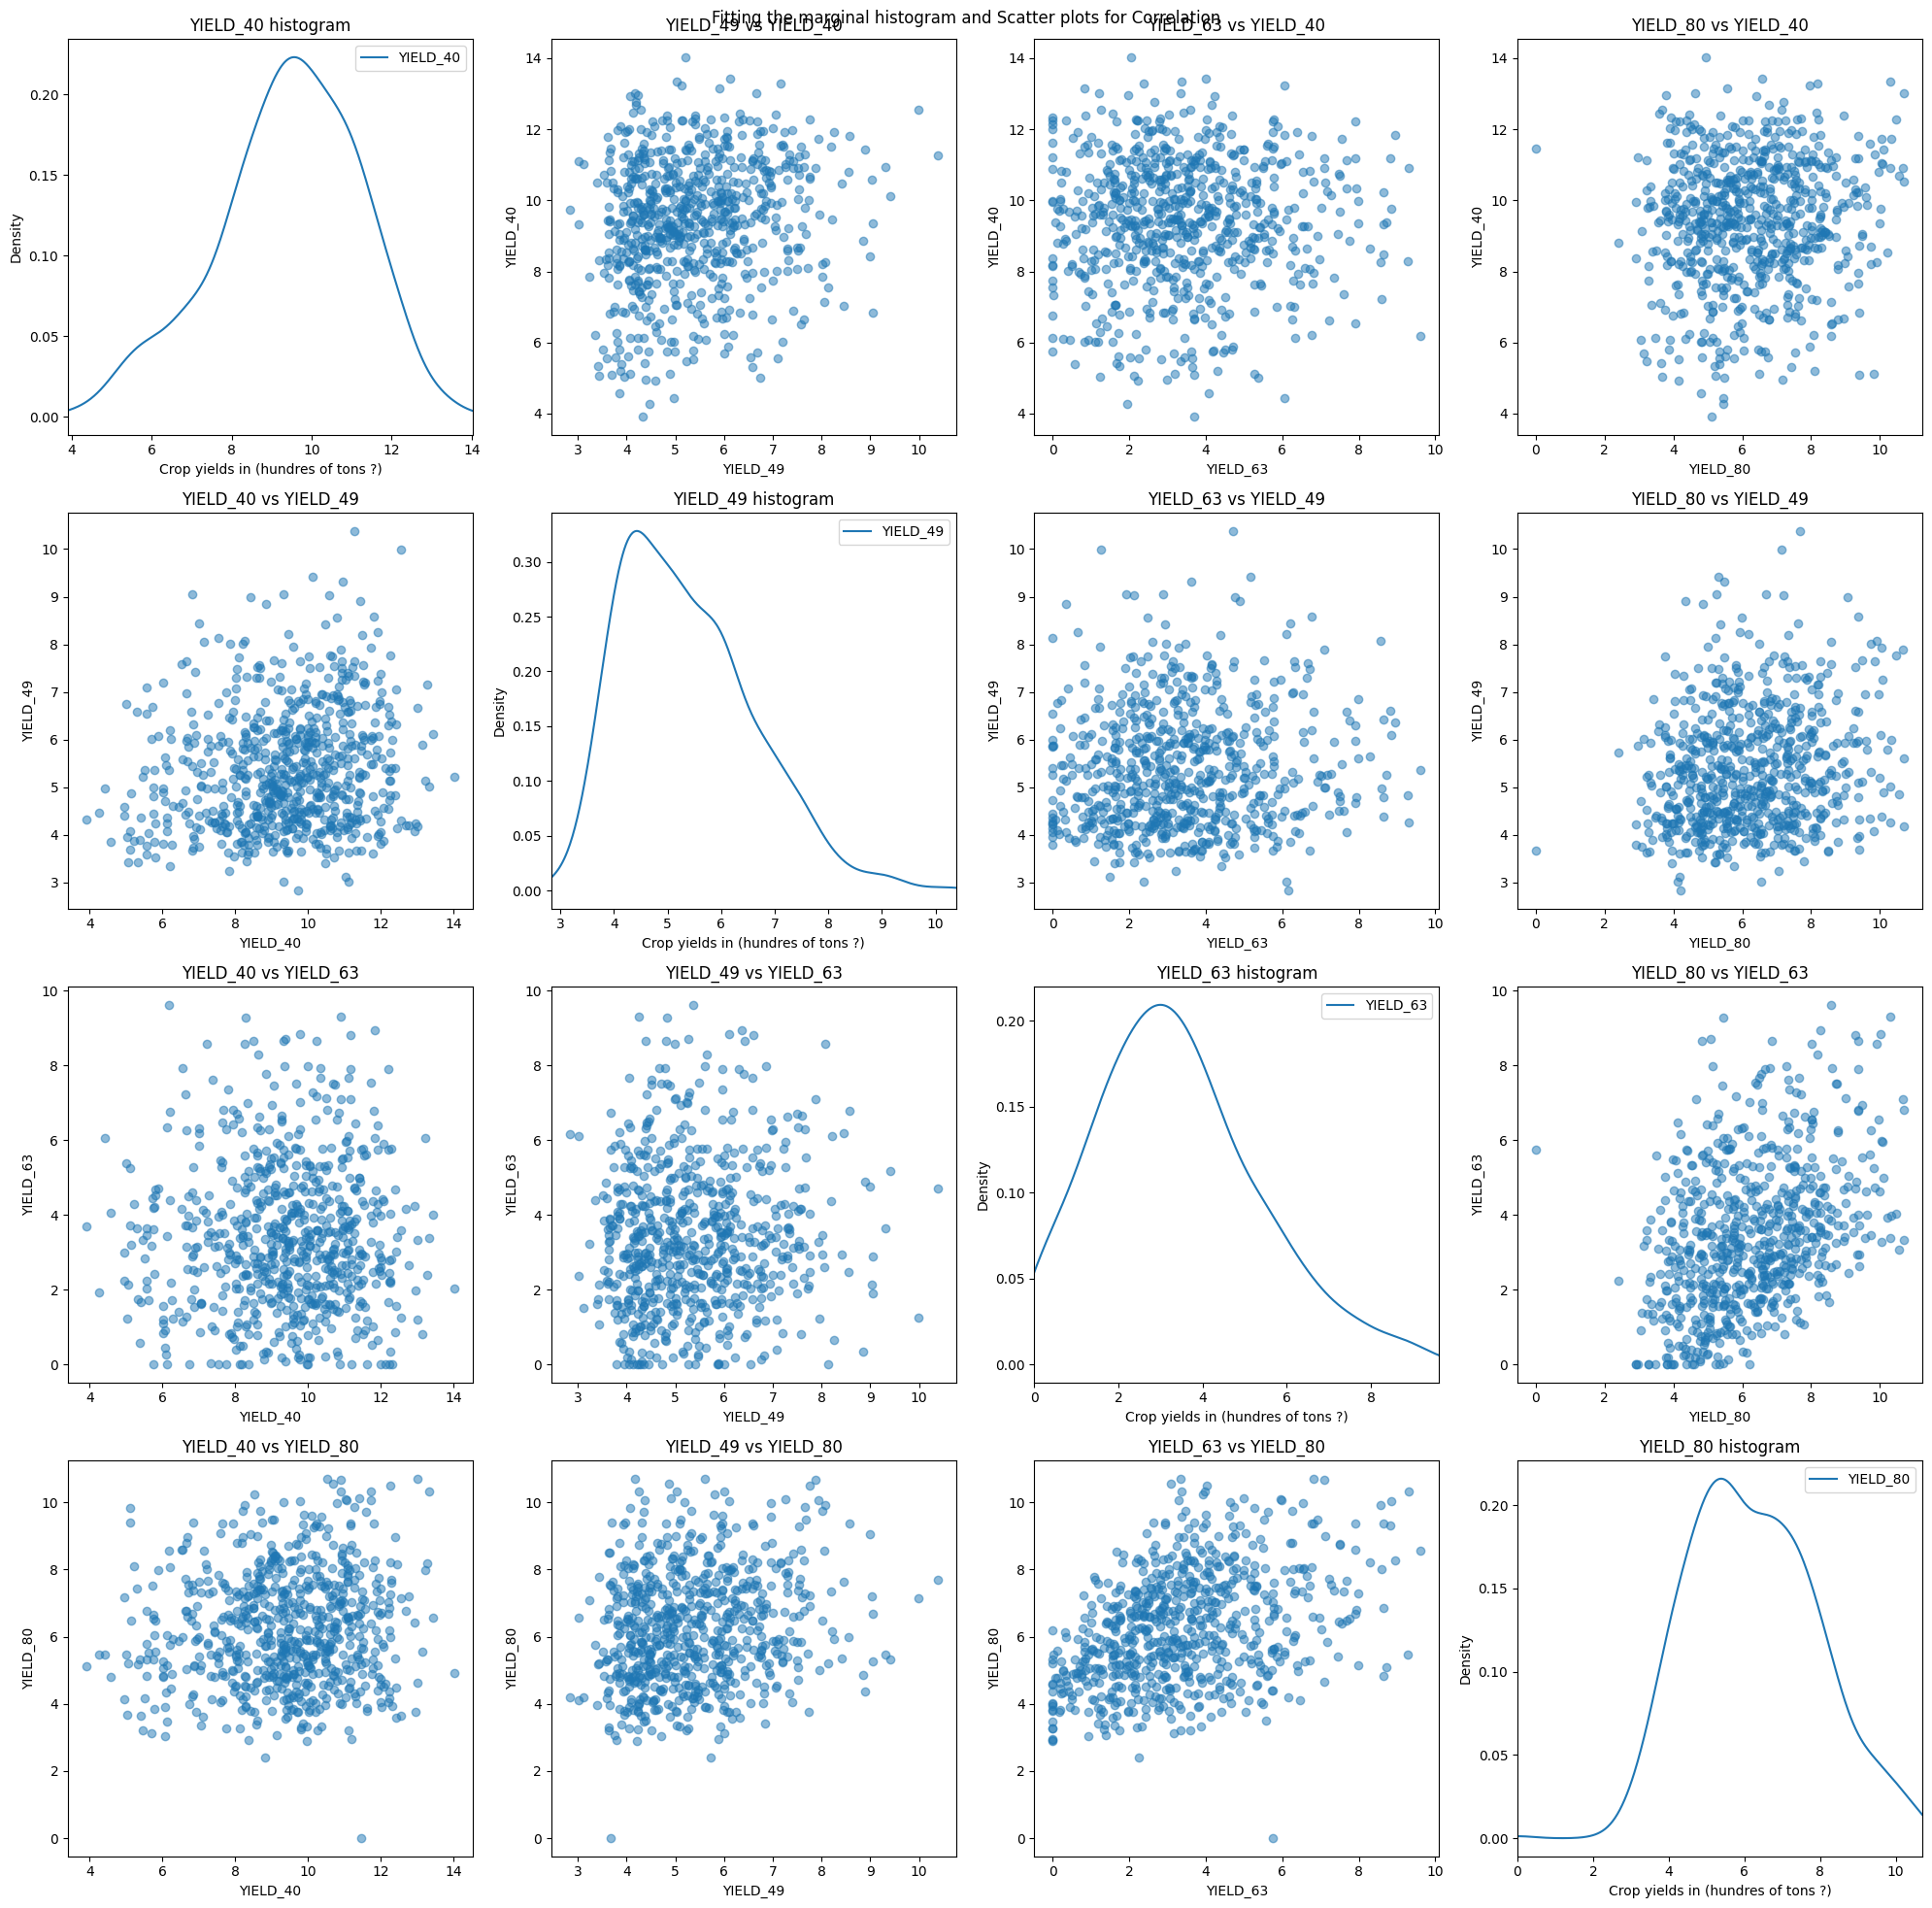

In [16]:
# Use only the YIELD data :
X= train_data[features]
X_train = X.copy()
X_test = test_data[features]

# Plotting density plots
plt.figure(figsize=(20, 20))
for k in range(len(X.columns)):
    yield_ind = X.columns[k]
    plt.subplot(4, 4, 5*k + 1)

    X[yield_ind].plot.density()
    mu, std = X[yield_ind].mean(), X[yield_ind].std()
    xmin, xmax = np.min(X[yield_ind]), np.max(X[yield_ind])
    plt.xlim(xmin, xmax)

    plt.title(yield_ind + " histogram")
    plt.xlabel("Crop yields in (hundres of tons ?)")
    plt.ylabel("Density")
    plt.legend()

# Plotting scatter plots for correlation
for i in range(len(X.columns)):
    for j in range(len(X.columns)):
        if i != j:
            plt.subplot(4, 4, 1 + i + 4*j)

            x = X.iloc[:, i]
            y = X.iloc[:, j]

            plt.scatter(x, y, alpha=0.5)
            plt.title(f"{X.columns[i]} vs {X.columns[j]}")
            plt.xlabel(X.columns[i])
            plt.ylabel(X.columns[j])

plt.suptitle("Fitting the marginal histogram and Scatter plots for Correlation")
plt.tight_layout()
plt.show()

# GAN directly on the yields

In [114]:
from GAN import Generator, Discriminator
from utils import ED_model_step
from utils import D_train, G_train
from utils import D_wasserstrain, G_wasserstrain
from utils import make_fake_data, make_fake_data_renorm

In [115]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device", device)

device cuda


In [116]:
batch_size = 16
g_hidden_dim = 16
d_hidden_dim = 32
lr = 0.001
latent_dim = 50
epochs = 1000

In [117]:
import torch.utils.data as data_utils

train = torch.tensor(X_train.values.astype(np.float32))
train_dataset = data_utils.TensorDataset(train)
train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

Standardizing the data may help

In [118]:
# standardize data
# means = train.mean(dim=0, keepdim=True)
# stds = train.std(dim=0, keepdim=True)
# train_normalized = (train - means) / stds
# test_normalized = (test - means) / stds

# train_dataset = data_utils.TensorDataset(train_normalized) 
# train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = args.batch_size, shuffle = True)


In [119]:
from tqdm import tqdm

dim = 4
G = torch.nn.DataParallel(Generator(latent_dim=latent_dim, g_hidden_dim=g_hidden_dim, g_output_dim=dim)).to(device)
D = torch.nn.DataParallel(Discriminator(d_input_dim=dim, d_hidden_dim=d_hidden_dim)).to(device)

G_optimizer = torch.optim.RMSprop(G.parameters(), lr=lr)
D_optimizer = torch.optim.RMSprop(D.parameters(), lr=lr, maximize=True)

d_losses, g_losses = [], []
start = time.time()
for k in range(epochs):
    with tqdm(enumerate(train_loader), total=len(train_loader), leave=False, desc=f"Epoch {k+1}") as pbar:
        for batch_idx, x in pbar:
            x = x[0]
            d_loss = D_train(latent_dim, x, G, D, D_optimizer, device)
            g_loss = G_train(latent_dim, x, G, D, G_optimizer, device)
            d_losses.append(d_loss)
            g_losses.append(g_loss)

        if (k + 1) %100 == 0:
            end = time.time()
            print(f"{k+1}: discriminator loss {d_loss:0.3f} generator loss {g_loss:0.3f} time {(end - start):0.2f}")

Epoch 1:   0%|          | 0/44 [00:00<?, ?it/s]

100: discriminator loss -1.362 generator loss 0.714 time 13.59


200: discriminator loss -1.347 generator loss 0.732 time 27.58


300: discriminator loss -1.384 generator loss 0.698 time 41.02


400: discriminator loss -1.386 generator loss 0.700 time 53.93


500: discriminator loss -1.386 generator loss 0.693 time 67.29


600: discriminator loss -1.387 generator loss 0.694 time 80.49


700: discriminator loss -1.387 generator loss 0.693 time 93.09


800: discriminator loss -1.386 generator loss 0.692 time 105.93


900: discriminator loss -1.386 generator loss 0.691 time 118.21


1000: discriminator loss -1.386 generator loss 0.692 time 132.07


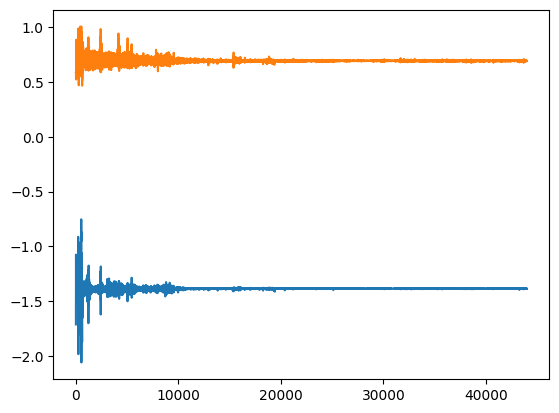

In [120]:
plt.plot(d_losses)
plt.plot(g_losses)

In [121]:
nb_samples = 1000
samples = make_fake_data("normal", n=nb_samples, latent_dim=latent_dim, G=G)

In [122]:
print("train SWD = {}".format(sliced_wasserstein_distance(X_train.values, samples, n_projections=1000)))
print("test SWD = {}".format(sliced_wasserstein_distance(X_test.values, samples, n_projections=1000)))

train SWD = 0.6158908066330409
test SWD = 0.5895148514343621


In [123]:
samples = pd.DataFrame(samples)

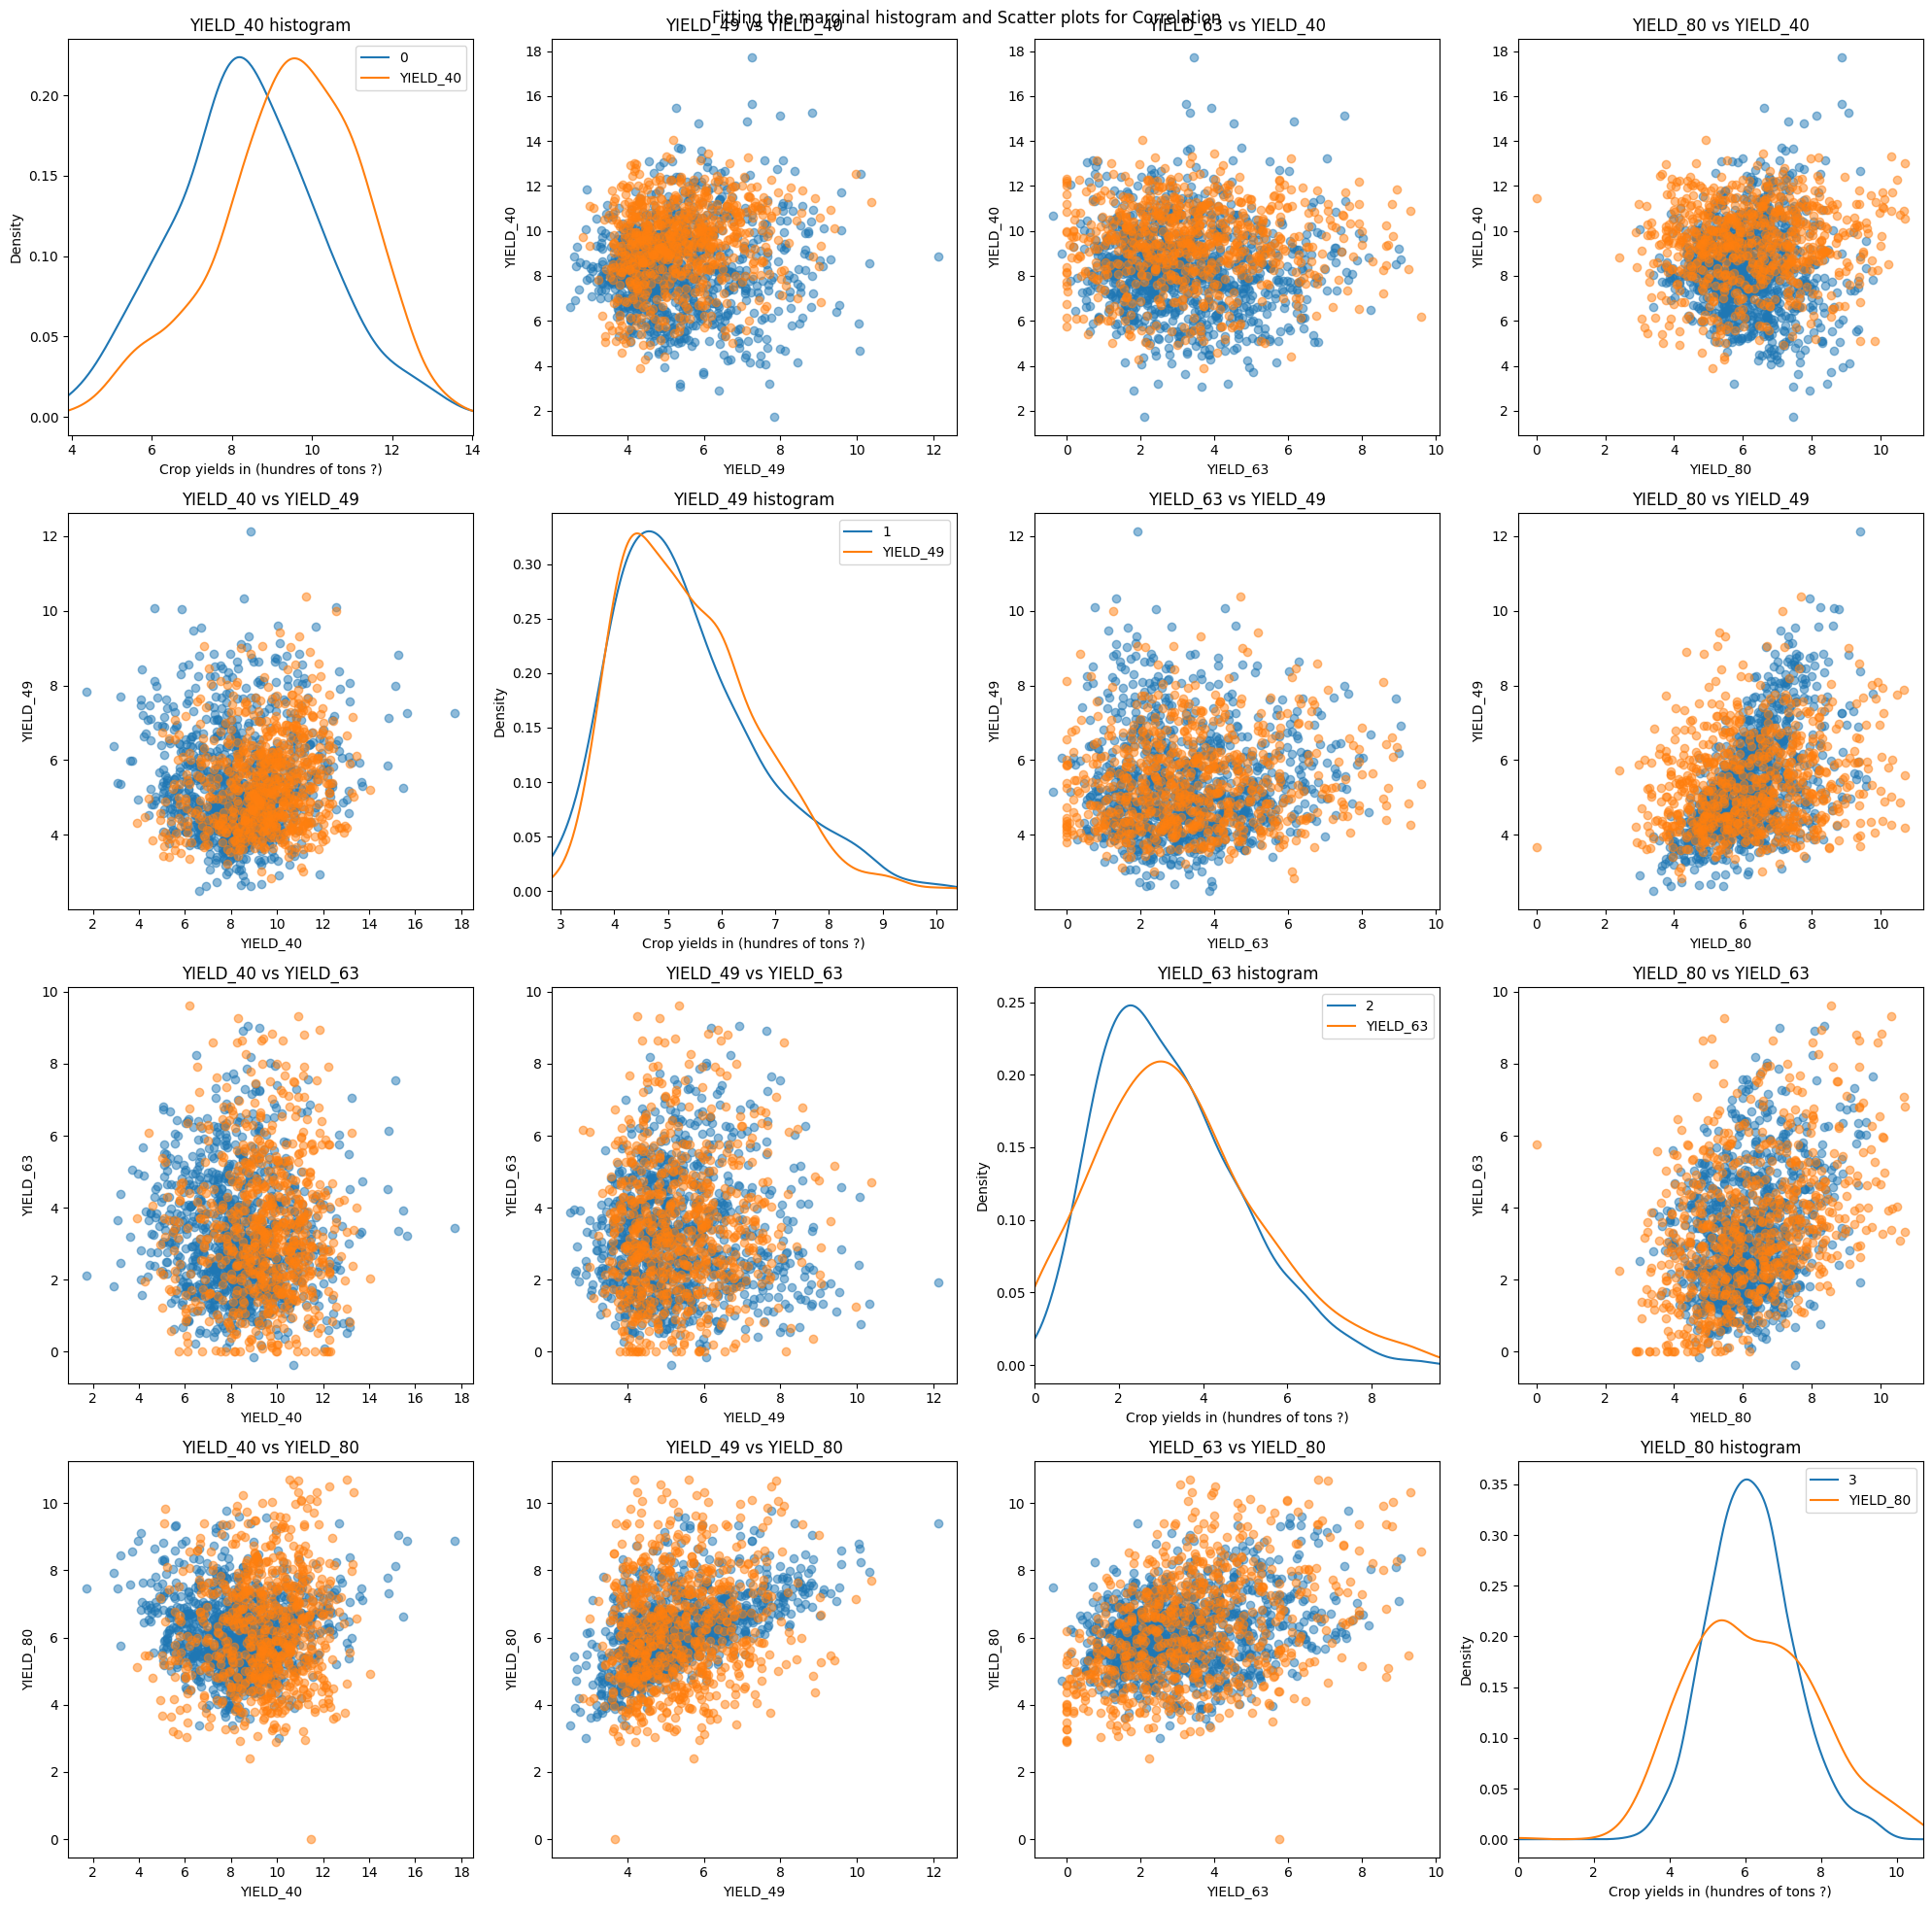

In [124]:
# Plotting density plots
plt.figure(figsize=(20, 20))
for k in range(samples.shape[1]):
    yield_ind = X.columns[k]
    plt.subplot(4, 4, 5*k + 1)

    samples[k].plot.density()
    X[yield_ind].plot.density()

    xmin, xmax = np.min(X[yield_ind]), np.max(X[yield_ind])
    plt.xlim(xmin, xmax)

    plt.title(yield_ind + " histogram")
    plt.xlabel("Crop yields in (hundres of tons ?)")
    plt.ylabel("Density")
    plt.legend()

# Plotting scatter plots for correlation
for i in range(samples.shape[1]):
    for j in range(samples.shape[1]):
        if i != j:
            plt.subplot(4, 4, 1 + i + 4*j)

            x = samples.iloc[:, i]
            y = samples.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            x = X.iloc[:, i]
            y = X.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            plt.title(f"{X.columns[i]} vs {X.columns[j]}")
            plt.xlabel(X.columns[i])
            plt.ylabel(X.columns[j])

plt.suptitle("Fitting the marginal histogram and Scatter plots for Correlation")
plt.tight_layout()
plt.show()


# Wasserstein GAN

Data normalization - important due to clipping performed

In [100]:
# transform data before
means = train.mean(dim=0, keepdim=True)
stds = train.std(dim=0, keepdim=True)
train_normalized = (train - means) / stds

In [101]:
train_dataset_normalized = data_utils.TensorDataset(train_normalized)
train_loader_normalized = data_utils.DataLoader(dataset = train_dataset_normalized, batch_size = batch_size, shuffle = True)

In [108]:
batch_size = 32
g_hidden_dim = 16
d_hidden_dim = 64
lr = 0.002
latent_dim = 32
epochs = 1000

In [109]:
from tqdm import tqdm

dim = 4
G = torch.nn.DataParallel(Generator(latent_dim=latent_dim, g_hidden_dim=g_hidden_dim, g_output_dim=dim)).to(device)
D = torch.nn.DataParallel(Discriminator(d_input_dim=dim, d_hidden_dim=d_hidden_dim)).to(device)

G_optimizer = torch.optim.RMSprop(G.parameters(), lr=lr)
D_optimizer = torch.optim.RMSprop(D.parameters(), lr=lr, maximize=True)

d_losses, g_losses = [], []
start = time.time()
for k in range(epochs):
    with tqdm(enumerate(train_loader_normalized), total=len(train_loader_normalized), leave=False, desc=f"Epoch {k+1}") as pbar:
        for batch_idx, x in pbar:
            x = x[0]
            d_loss = D_wasserstrain(latent_dim, x, G, D, D_optimizer, device)
            if batch_idx % 5 == 0:
                g_loss = G_wasserstrain(latent_dim, x, G, D, G_optimizer, device)
                d_losses.append(d_loss)
                g_losses.append(g_loss)

        if (k + 1) %100 == 0:
            end = time.time()
            print(f"{k+1}: discriminator loss {d_loss:0.3f} generator loss {g_loss:0.3f} time {(end - start):0.2f}")

Epoch 1:   0%|          | 0/22 [00:00<?, ?it/s]

100: discriminator loss 0.000 generator loss -0.498 time 5.04


200: discriminator loss 0.000 generator loss -0.499 time 9.52


300: discriminator loss 0.000 generator loss -0.500 time 13.90


400: discriminator loss 0.000 generator loss -0.500 time 18.07


500: discriminator loss 0.000 generator loss -0.500 time 22.22


600: discriminator loss 0.000 generator loss -0.500 time 26.52


700: discriminator loss 0.000 generator loss -0.500 time 30.78


800: discriminator loss 0.000 generator loss -0.499 time 35.02


900: discriminator loss 0.000 generator loss -0.498 time 39.28


1000: discriminator loss 0.000 generator loss -0.501 time 43.54


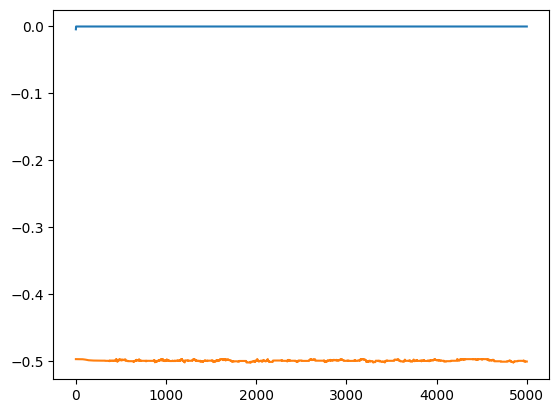

In [110]:
plt.plot(d_losses)
plt.plot(g_losses)

In [111]:
nb_samples = 1000
samples = make_fake_data_renorm("normal", n=nb_samples, latent_dim=latent_dim, G=G, means=means, stds=stds)
samples = pd.DataFrame(samples)

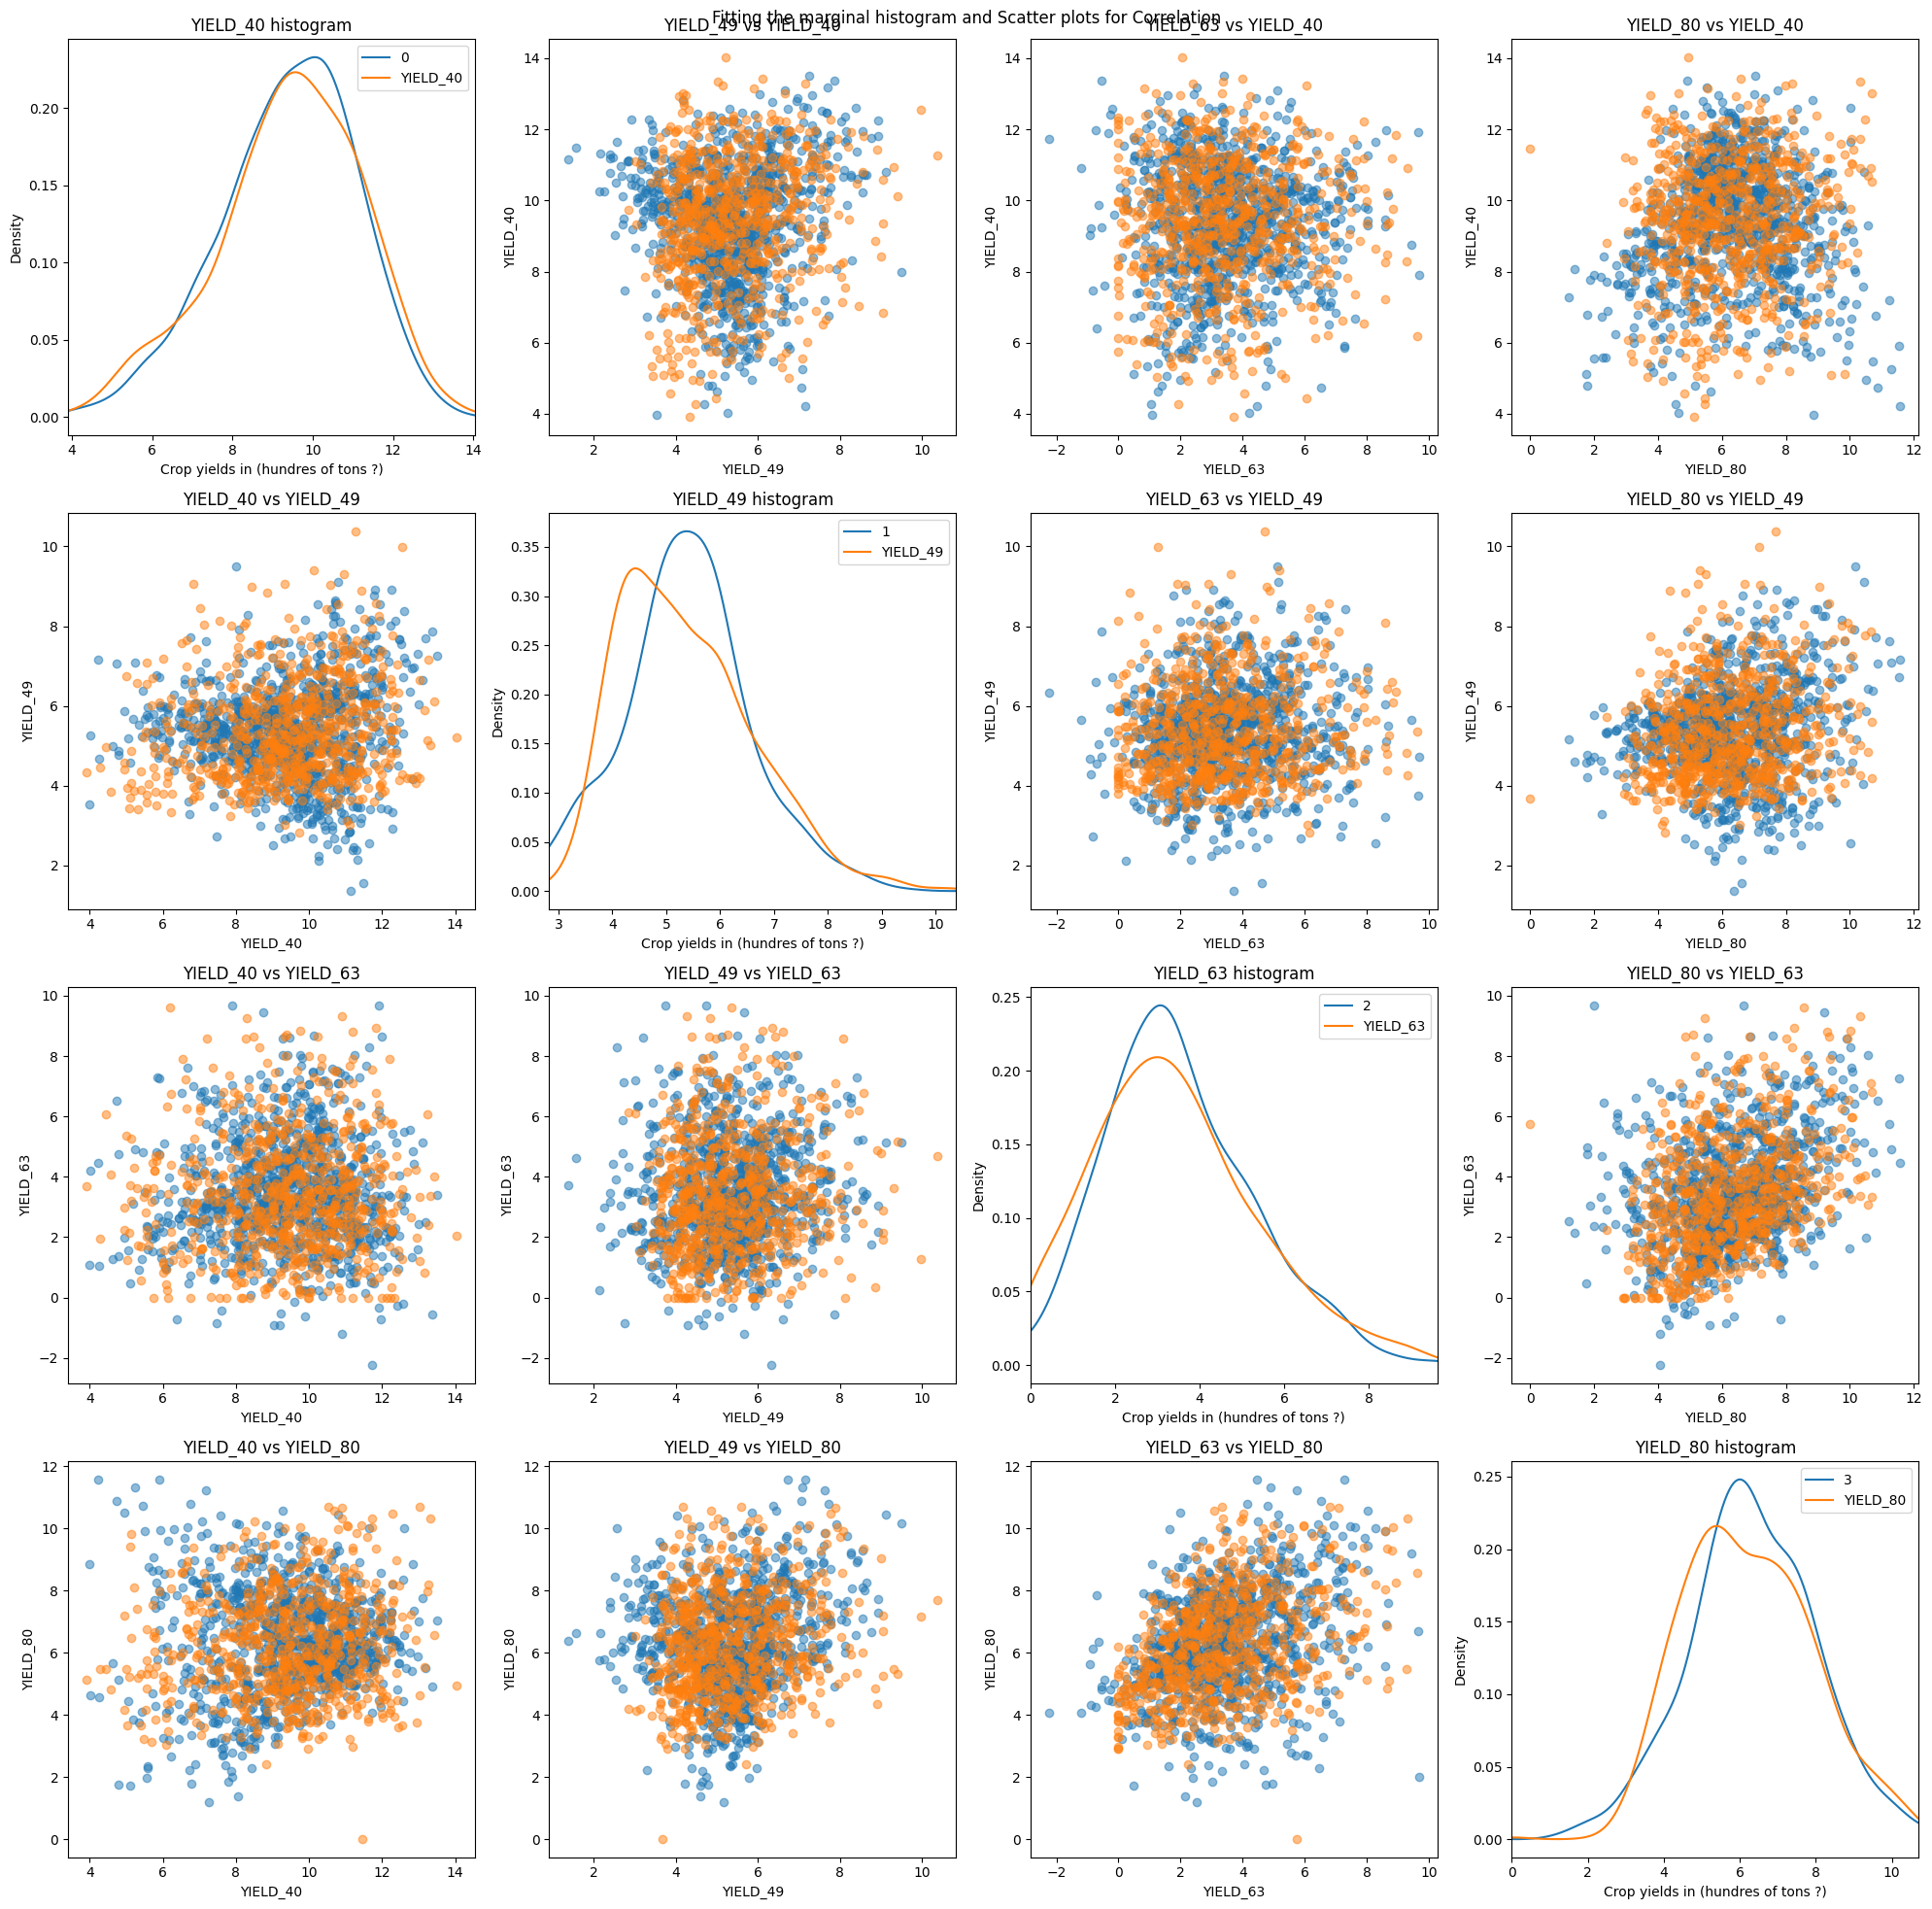

In [112]:
# Plotting density plots
plt.figure(figsize=(20, 20))
for k in range(samples.shape[1]):
    yield_ind = X.columns[k]
    plt.subplot(4, 4, 5*k + 1)

    samples[k].plot.density()
    X[yield_ind].plot.density()

    xmin, xmax = np.min(X[yield_ind]), np.max(X[yield_ind])
    plt.xlim(xmin, xmax)

    plt.title(yield_ind + " histogram")
    plt.xlabel("Crop yields in (hundres of tons ?)")
    plt.ylabel("Density")
    plt.legend()

# Plotting scatter plots for correlation
for i in range(samples.shape[1]):
    for j in range(samples.shape[1]):
        if i != j:
            plt.subplot(4, 4, 1 + i + 4*j)

            x = samples.iloc[:, i]
            y = samples.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            x = X.iloc[:, i]
            y = X.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            plt.title(f"{X.columns[i]} vs {X.columns[j]}")
            plt.xlabel(X.columns[i])
            plt.ylabel(X.columns[j])

plt.suptitle("Fitting the marginal histogram and Scatter plots for Correlation")
plt.tight_layout()
plt.show()

In [113]:
nb_samples = 1000
samples = make_fake_data_renorm("normal", n=nb_samples, latent_dim=latent_dim, G=G, means=means, stds=stds)
print("train SWD = {}".format(sliced_wasserstein_distance(X_train.values, samples, n_projections=1000)))
print("test SWD = {}".format(sliced_wasserstein_distance(X_test.values, samples, n_projections=1000)))

train SWD = 0.22413274475813247
test SWD = 0.35082820931637104


# Energy distance minimization

In [43]:
import torch.utils.data as data_utils

train = torch.tensor(X.values.astype(np.float32))
train_dataset = data_utils.TensorDataset(train)
train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

In [44]:
dim = 4
G = torch.nn.DataParallel(Generator(latent_dim=latent_dim, g_hidden_dim=g_hidden_dim, g_output_dim=dim)).to(device)

G_optimizer = torch.optim.RMSprop(G.parameters(), lr=lr)

losses = []
start = time.time()
for k in range(epochs):
    with tqdm(enumerate(train_loader), total=len(train_loader), leave=False, desc=f"Epoch {k+1}") as pbar:
        for batch_idx, x in pbar:
            x = x[0]
            loss = ED_model_step(latent_dim, x, G, G_optimizer, device, "normal")
            losses.append(loss)

        if (k + 1) %100 == 0:
            end = time.time()
            print(f"{k+1}: discriminator loss {d_loss:0.3f} generator loss {g_loss:0.3f} time {(end - start):0.2f}")

Epoch 1:   0%|          | 0/22 [00:00<?, ?it/s]

100: discriminator loss 0.000 generator loss -0.502 time 2.87


200: discriminator loss 0.000 generator loss -0.502 time 5.73


300: discriminator loss 0.000 generator loss -0.502 time 8.35


400: discriminator loss 0.000 generator loss -0.502 time 10.85


500: discriminator loss 0.000 generator loss -0.502 time 13.54


600: discriminator loss 0.000 generator loss -0.502 time 16.20


700: discriminator loss 0.000 generator loss -0.502 time 18.66


800: discriminator loss 0.000 generator loss -0.502 time 20.92


900: discriminator loss 0.000 generator loss -0.502 time 23.44


1000: discriminator loss 0.000 generator loss -0.502 time 25.88


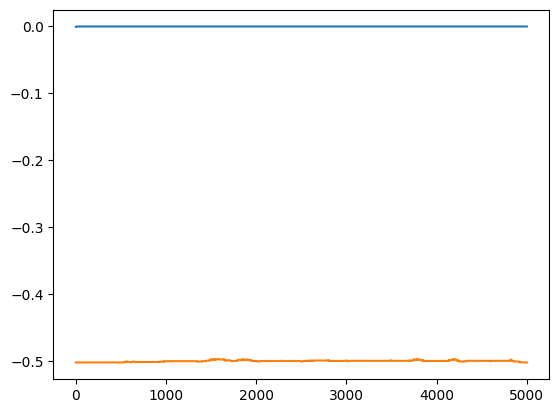

In [45]:
plt.plot(d_losses)
plt.plot(g_losses)

In [46]:
samples = make_fake_data("normal", n=289, latent_dim=latent_dim, G=G)
samples = pd.DataFrame(samples)

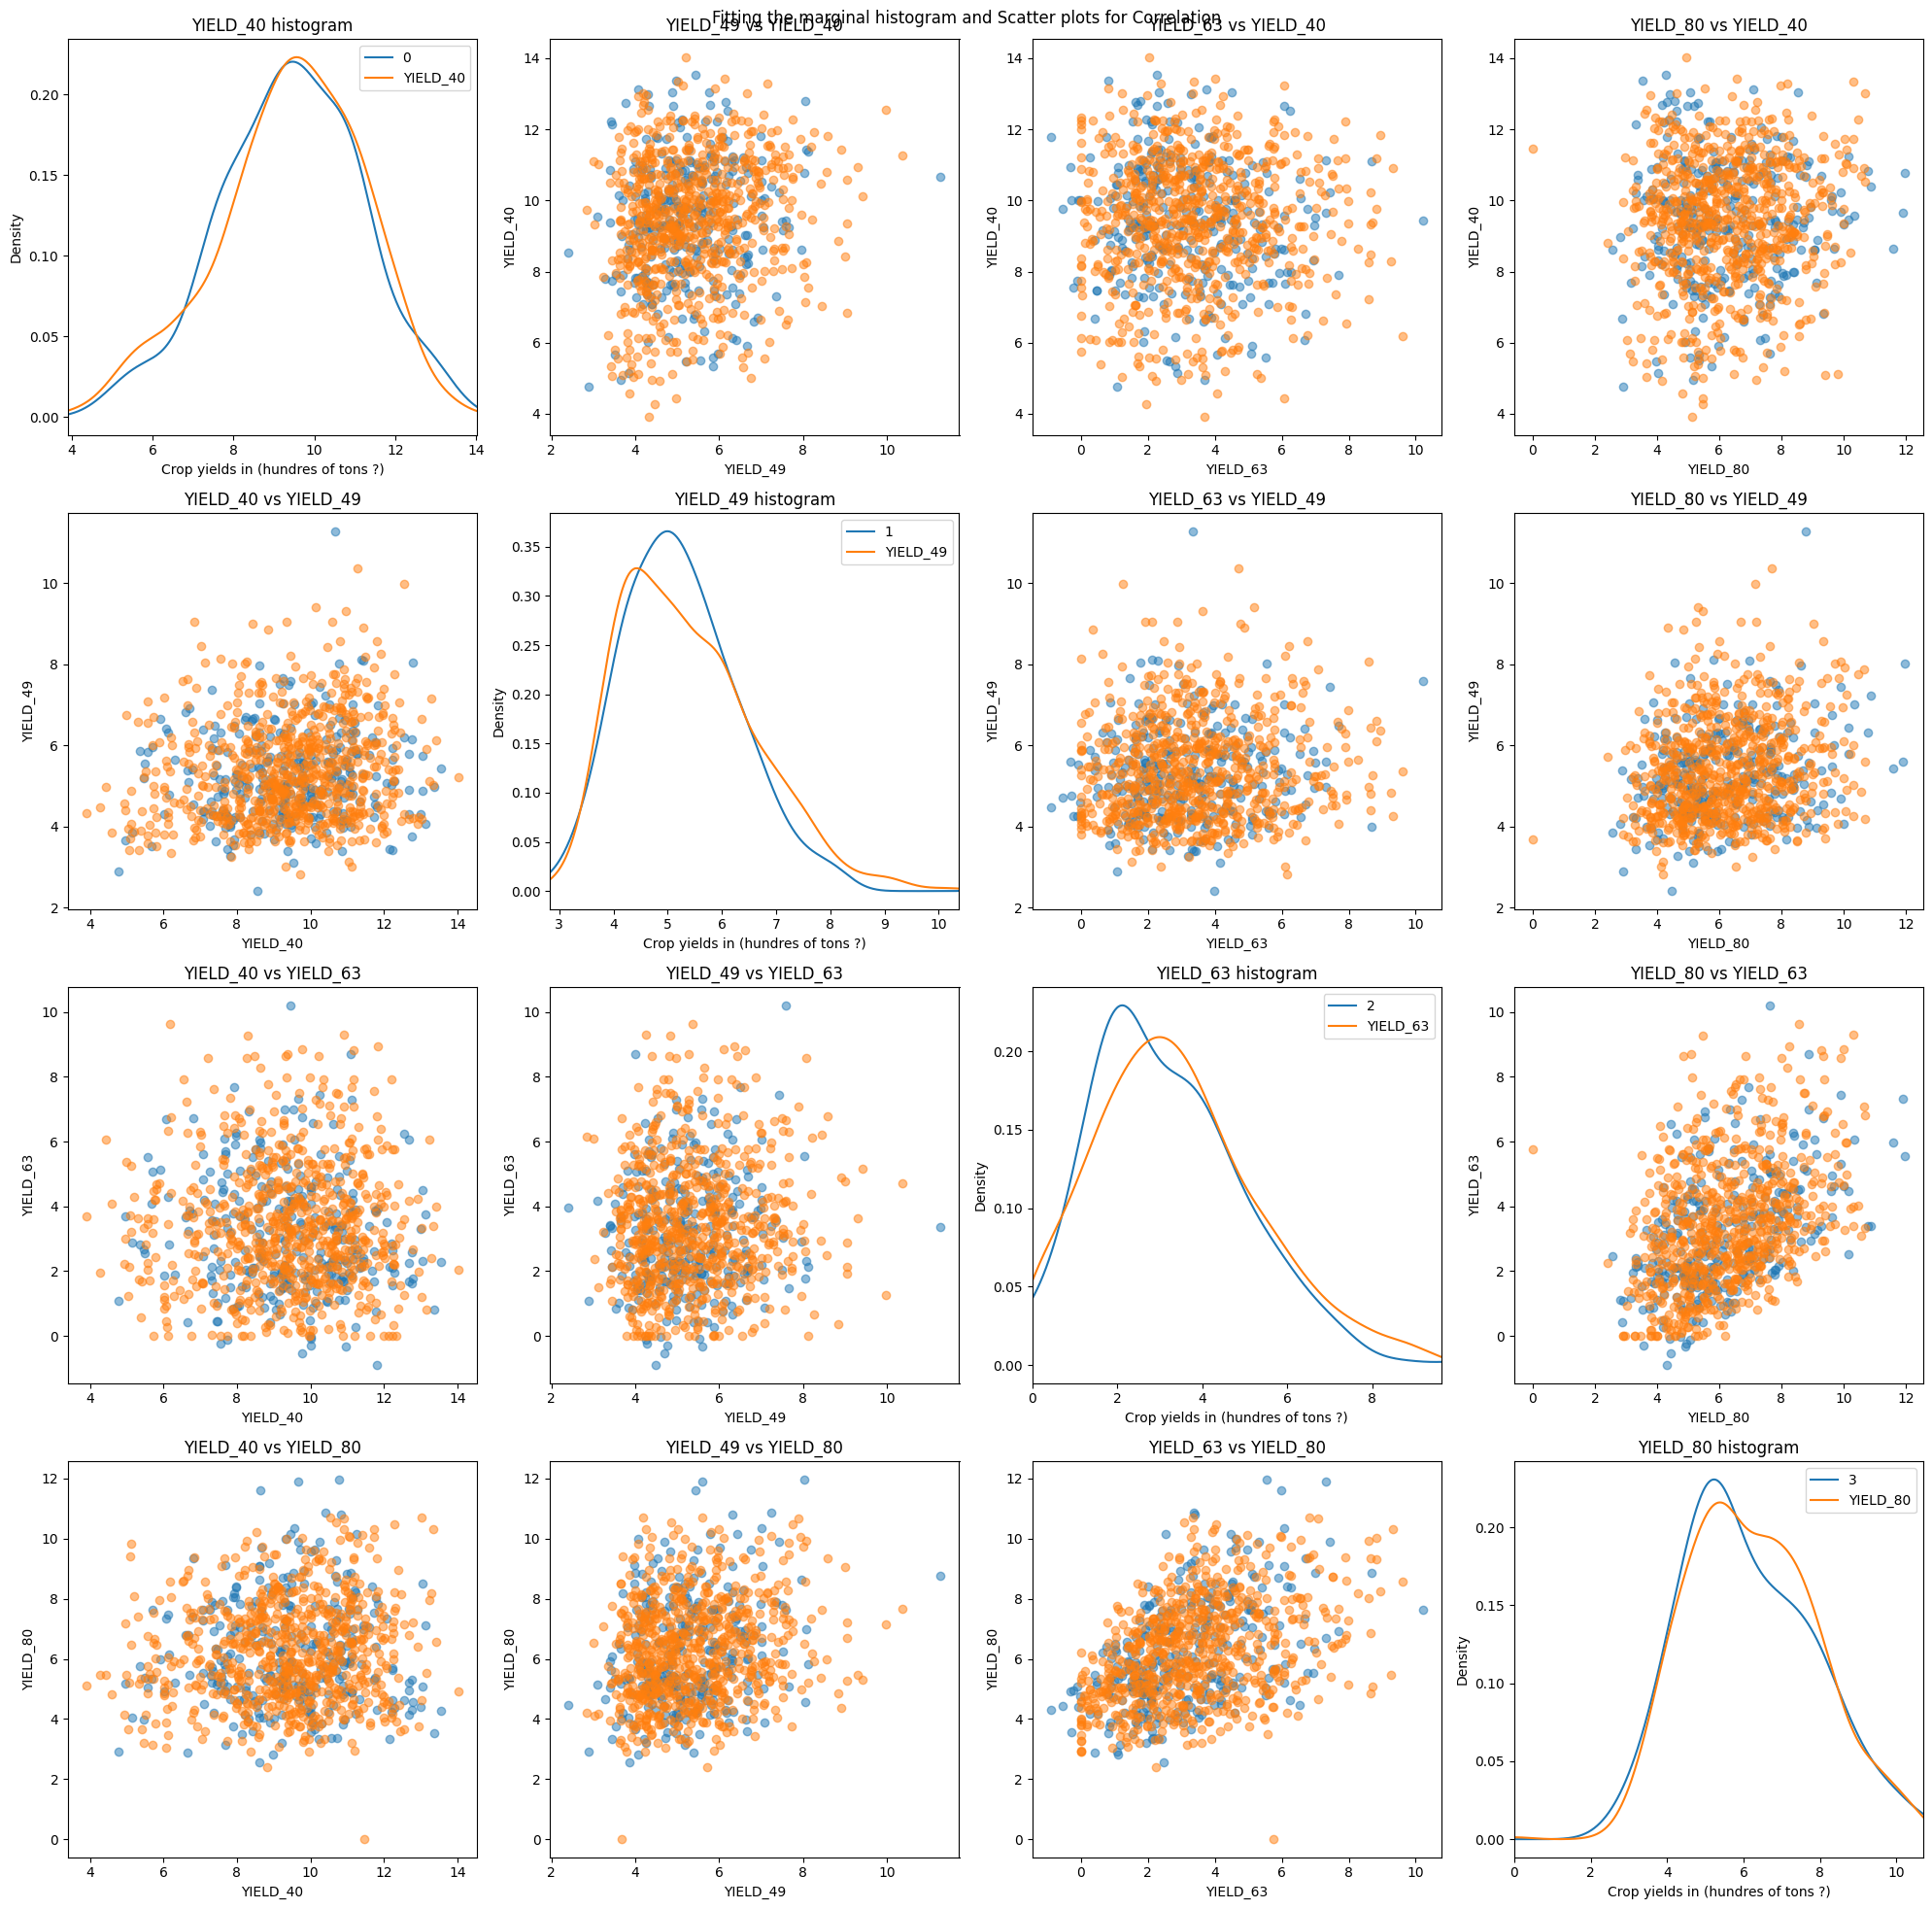

In [47]:
# Plotting density plots
plt.figure(figsize=(20, 20))
for k in range(samples.shape[1]):
    yield_ind = X.columns[k]
    plt.subplot(4, 4, 5*k + 1)

    samples[k].plot.density()
    X[yield_ind].plot.density()

    xmin, xmax = np.min(X[yield_ind]), np.max(X[yield_ind])
    plt.xlim(xmin, xmax)

    plt.title(yield_ind + " histogram")
    plt.xlabel("Crop yields in (hundres of tons ?)")
    plt.ylabel("Density")
    plt.legend()

# Plotting scatter plots for correlation
for i in range(samples.shape[1]):
    for j in range(samples.shape[1]):
        if i != j:
            plt.subplot(4, 4, 1 + i + 4*j)

            x = samples.iloc[:, i]
            y = samples.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            x = X.iloc[:, i]
            y = X.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            plt.title(f"{X.columns[i]} vs {X.columns[j]}")
            plt.xlabel(X.columns[i])
            plt.ylabel(X.columns[j])

plt.suptitle("Fitting the marginal histogram and Scatter plots for Correlation")
plt.tight_layout()
plt.show()

In [48]:
nb_samples = 1000
samples = make_fake_data("normal", n=nb_samples, latent_dim=latent_dim, G=G)
print("train SWD = {}".format(sliced_wasserstein_distance(X_train.values, samples, n_projections=1000)))
print("test SWD = {}".format(sliced_wasserstein_distance(X_test.values, samples, n_projections=1000)))

train SWD = 0.19480452295845
test SWD = 0.25681278465304036


# Energy distance - larger

In [52]:
X_train.shape

(700, 4)

In [51]:
X_test.shape

(300, 4)

In [ ]:
X.shape

In [69]:
batch_size = 32
g_hidden_dim = 16
d_hidden_dim = 16
lr = 0.001
latent_dim = 4
epochs = 1000

In [70]:
train = torch.tensor(X.values.astype(np.float32))
train_dataset = data_utils.TensorDataset(train)
train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

dim = 4
G = torch.nn.DataParallel(Generator(latent_dim=latent_dim, g_hidden_dim=g_hidden_dim, g_output_dim=dim)).to(device)

G_optimizer = torch.optim.RMSprop(G.parameters(), lr=lr)

losses = []
start = time.time()
for k in range(epochs):
    with tqdm(enumerate(train_loader), total=len(train_loader), leave=False, desc=f"Epoch {k+1}") as pbar:
        for batch_idx, x in pbar:
            x = x[0]
            loss = ED_model_step(latent_dim, x, G, G_optimizer, device, "normal")
            losses.append(loss)

        if (k + 1) %100 == 0:
            end = time.time()
            print(f"{k+1}: discriminator loss {d_loss:0.3f} generator loss {g_loss:0.3f} time {(end - start):0.2f}")

100: discriminator loss 0.000 generator loss -0.502 time 2.76


200: discriminator loss 0.000 generator loss -0.502 time 5.40


300: discriminator loss 0.000 generator loss -0.502 time 7.99


400: discriminator loss 0.000 generator loss -0.502 time 10.58


500: discriminator loss 0.000 generator loss -0.502 time 12.93


600: discriminator loss 0.000 generator loss -0.502 time 15.35


700: discriminator loss 0.000 generator loss -0.502 time 17.88


800: discriminator loss 0.000 generator loss -0.502 time 20.24


900: discriminator loss 0.000 generator loss -0.502 time 22.71


1000: discriminator loss 0.000 generator loss -0.502 time 25.12


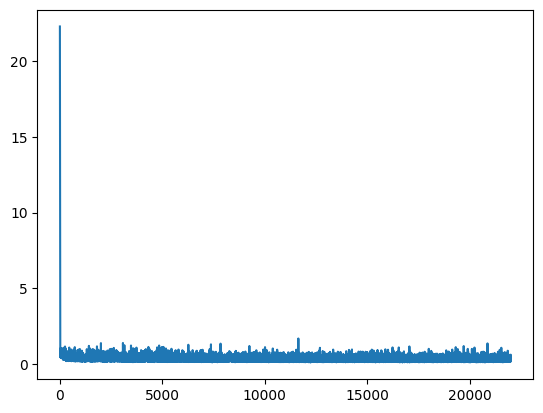

In [71]:
plt.plot(losses)

In [72]:
samples = make_fake_data("normal", n=289, latent_dim=latent_dim, G=G)
samples = pd.DataFrame(samples)

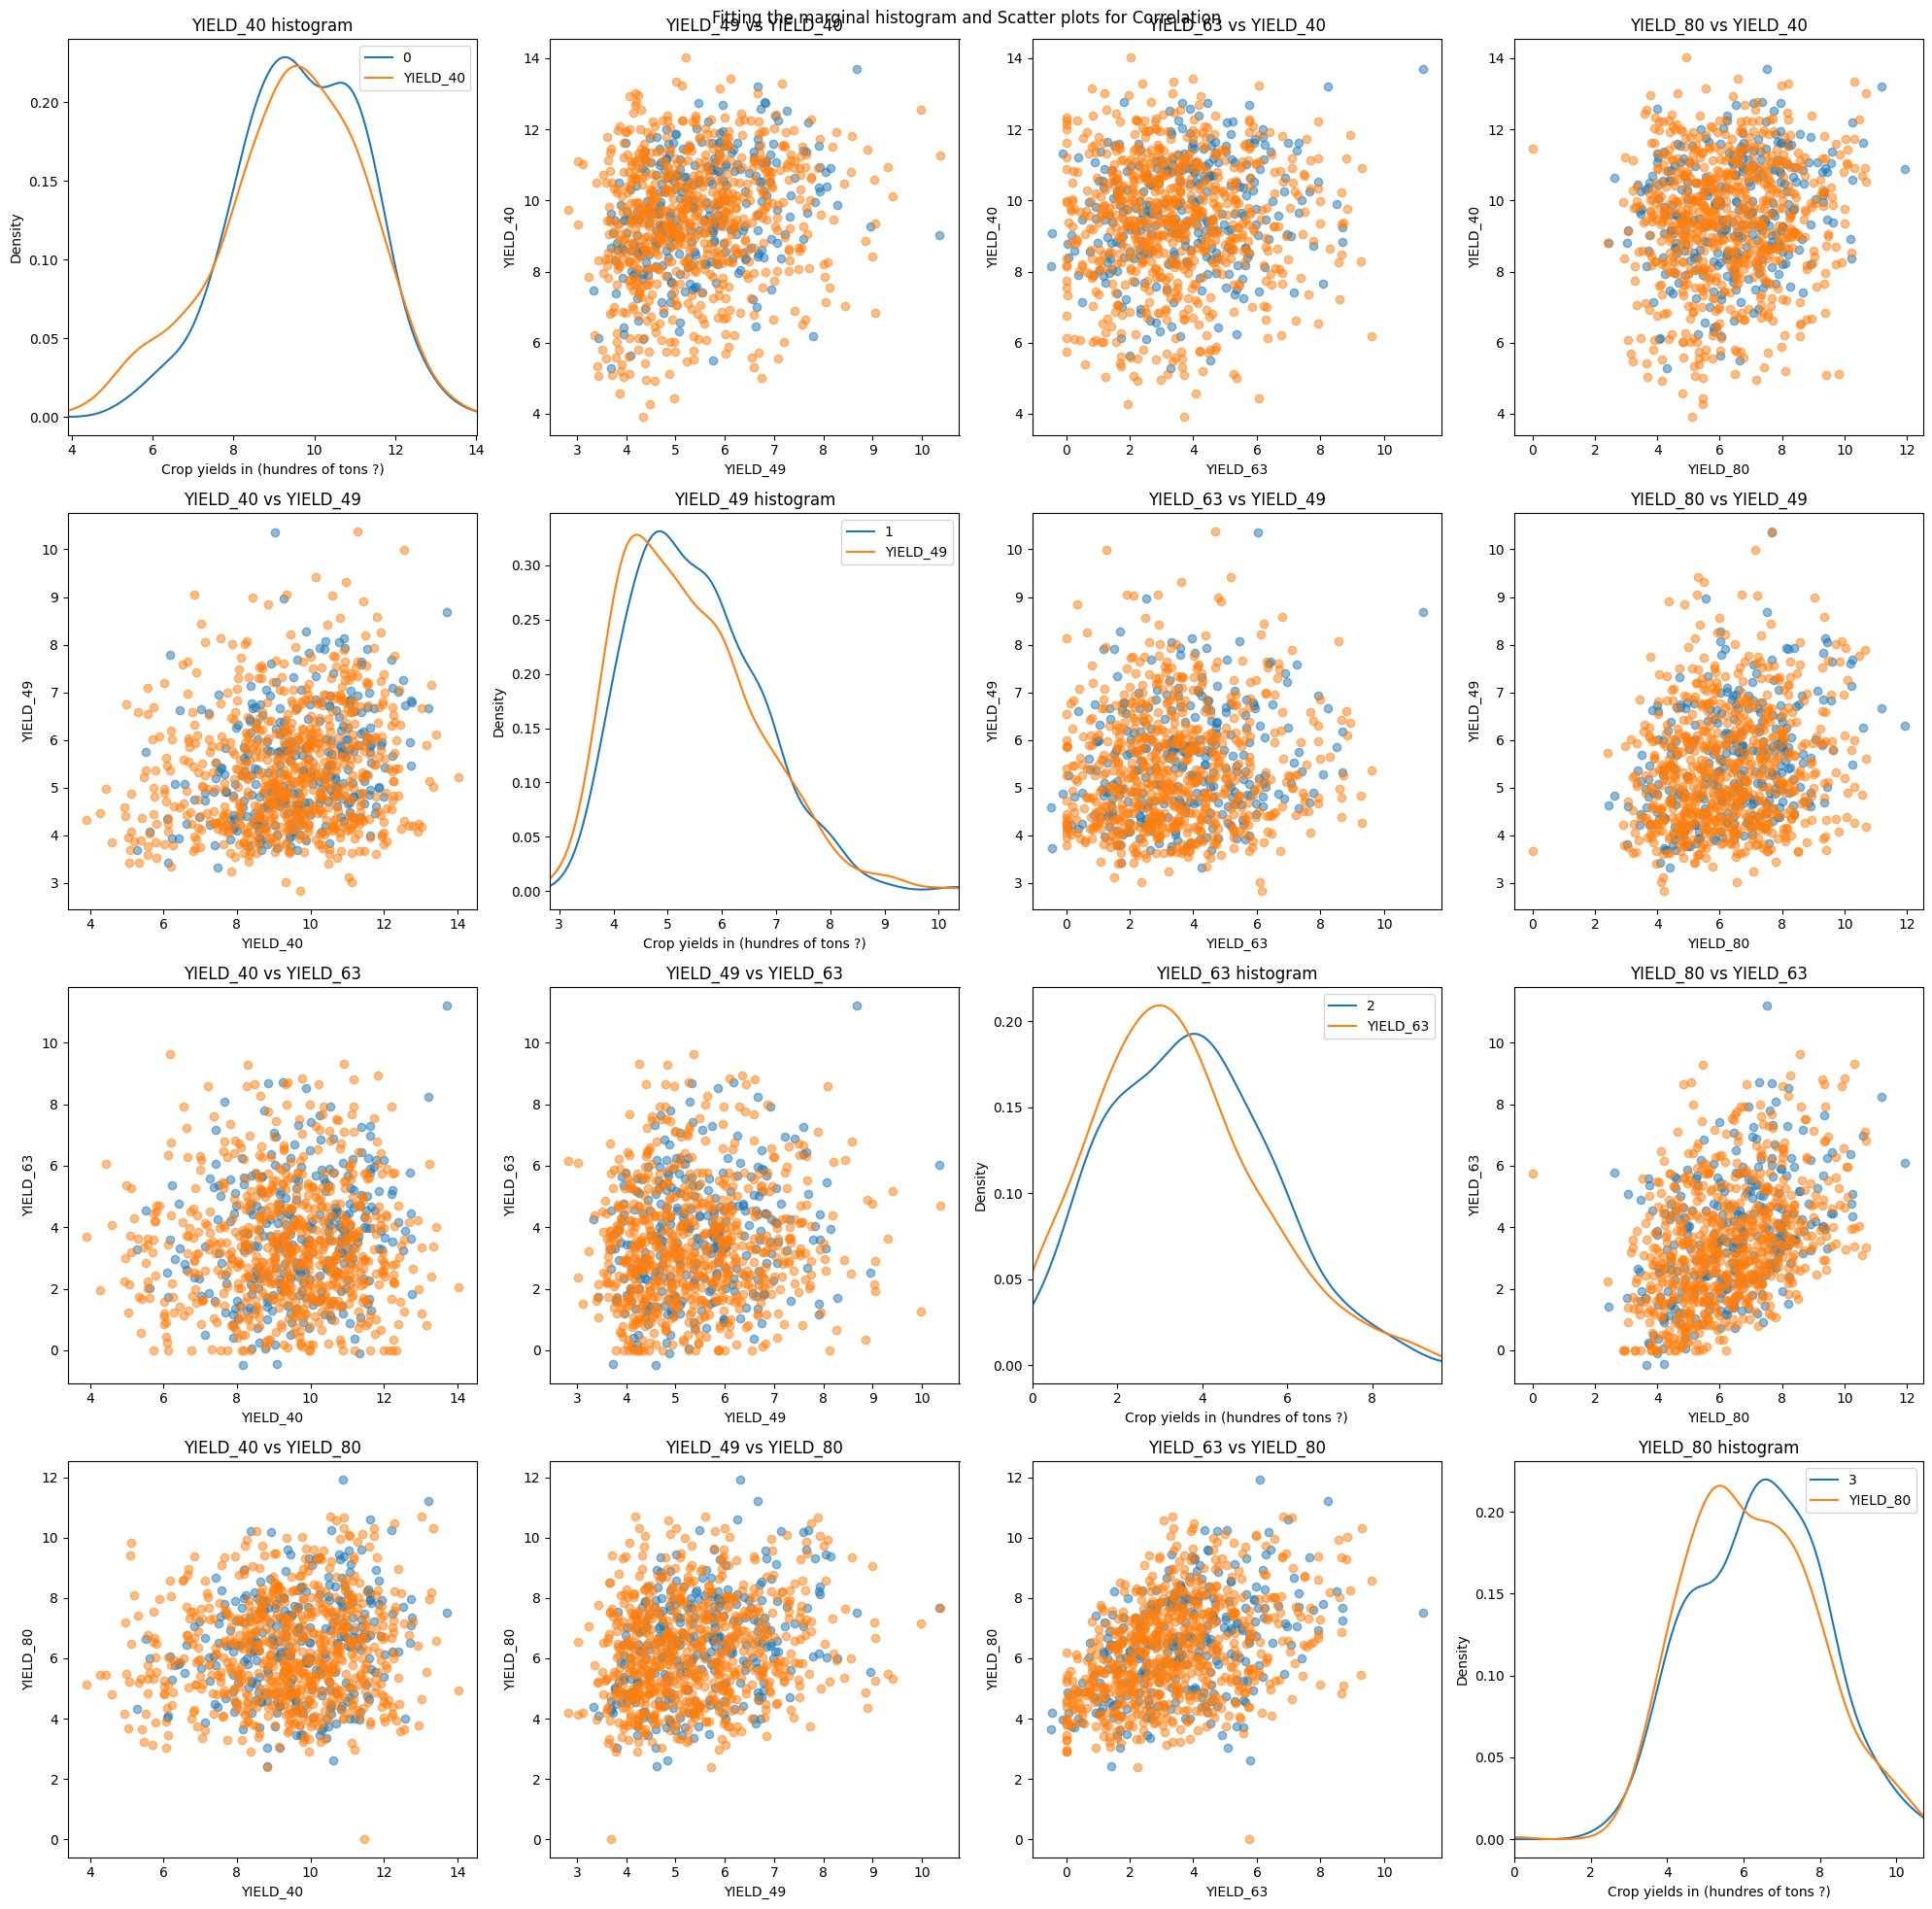

In [73]:
# Plotting density plots
plt.figure(figsize=(20, 20))
for k in range(samples.shape[1]):
    yield_ind = X.columns[k]
    plt.subplot(4, 4, 5*k + 1)

    samples[k].plot.density()
    X[yield_ind].plot.density()

    xmin, xmax = np.min(X[yield_ind]), np.max(X[yield_ind])
    plt.xlim(xmin, xmax)

    plt.title(yield_ind + " histogram")
    plt.xlabel("Crop yields in (hundres of tons ?)")
    plt.ylabel("Density")
    plt.legend()

# Plotting scatter plots for correlation
for i in range(samples.shape[1]):
    for j in range(samples.shape[1]):
        if i != j:
            plt.subplot(4, 4, 1 + i + 4*j)

            x = samples.iloc[:, i]
            y = samples.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            x = X.iloc[:, i]
            y = X.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            plt.title(f"{X.columns[i]} vs {X.columns[j]}")
            plt.xlabel(X.columns[i])
            plt.ylabel(X.columns[j])

plt.suptitle("Fitting the marginal histogram and Scatter plots for Correlation")
plt.tight_layout()
plt.show()

In [74]:
nb_samples = 1000
samples = make_fake_data("normal", n=nb_samples, latent_dim=latent_dim, G=G)
print("train SWD = {}".format(sliced_wasserstein_distance(X_train.values, samples, n_projections=1000)))
print("test SWD = {}".format(sliced_wasserstein_distance(X_test.values, samples, n_projections=1000)))

train SWD = 0.17908580801157287
test SWD = 0.2797430987413919
